#### Installing dependencies

In [ ]:
!sudo apt install octave

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
octave is already the newest version (6.4.0-2).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:
!pip install torchmetrics

In [ ]:
!pip install oct2py

#### Importing Pkgs

In [ ]:
from oct2py import Oct2Py

oc = Oct2Py();

In [ ]:
import torch;
import torch.nn as nn;
import torch.nn.functional as F;
from torch.utils.data import Dataset, DataLoader;

import matplotlib.pyplot as plt;
import numpy as np;

from tqdm import tqdm;

In [ ]:
from torchmetrics.classification import Accuracy,Precision, Recall, F1Score, ConfusionMatrix;

In [ ]:
import pandas as pd;
import random;

In [ ]:
import json;

In [ ]:
import os;
import os.path;

In [ ]:
import re;

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu");
print(device);

cuda


In [ ]:
seed = 42;

In [ ]:
np.random.seed(seed);
random.seed(seed);
torch.manual_seed(seed);

if torch.cuda.is_available():
    torch.cuda.manual_seed(seed);
    torch.cuda.manual_seed_all(seed);

In [ ]:
def getYLabel(filename):
    output = {
            "K" : 0,
            "KA" : 1,
            "KI" : 2
    };

    code = filename.split("_")[3];

    if code.startswith("KA"):
        return output["KA"];
    elif code.startswith("KI"):
        return output["KI"];
    else:
        return output["K"];

#### Dataset Creation

In [ ]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, code, healty_end_points, faulty_end_points, oc, width, signal="vibration"):
        self.root_dir = root_dir;
        self.healty_end_points = healty_end_points;
        self.faulty_end_points = faulty_end_points;
        self.oc = oc;

        self.width = width;

        self.X = [];
        self.Y = [];

        self.signal = signal;

        for healty_end_point in self.healty_end_points:
            for mat_healthy_end_point in os.listdir(os.path.join(self.root_dir, healty_end_point)):
                if mat_healthy_end_point.endswith(".mat") and mat_healthy_end_point.startswith(code):
                    self.X.append(os.path.join(self.root_dir, healty_end_point, mat_healthy_end_point));
                    self.Y.append(getYLabel(mat_healthy_end_point));

        for faulty_end_point in self.faulty_end_points:
            for mat_faulty_end_point in os.listdir(os.path.join(self.root_dir, faulty_end_point)):
                if mat_faulty_end_point.endswith(".mat") and mat_faulty_end_point.startswith(code):
                    self.X.append(os.path.join(self.root_dir, faulty_end_point, mat_faulty_end_point));
                    self.Y.append(getYLabel(mat_faulty_end_point));


    def __len__(self):
        return len(self.X);

    def __getitem__(self, idx):
        data = self.oc.load(self.X[idx]);
        field = list(data.keys())[0];

        x = data[field]['Y']['Data'][0][6].flatten();

        w = x.shape[-1];

        if(w < self.width):
            x = np.pad(x, pad_width = (0, self.width - w), mode = 'constant');
        elif(w > self.width):
            x = x[:self.width];


        y = torch.full((250,),self.Y[idx]).to(torch.long);
        X = torch.tensor(x).to(torch.float32);

        X = X - X.mean();
        X = X / X.std();

        return X.reshape(250,1024), y;

In [ ]:
def getCode(N, M, F):
    return f"N{N:02}" + "_" + f"M{M:02}" + "_" + f"F{F:02}";

In [ ]:
code = getCode(15, 7, 10);

In [ ]:
# ratios = {2:5, 6:5, 8:5}
def getDataset(code, signal = "vibration", width=256000, ratios="6:5"):
    root_dir = "/content/drive/MyDrive/PaderbornExtracted";
    healty_end_points = ["K001","K002","K003","K004","K005","K006"];
    faulty_end_points_inner = ["KI04","KI14","KI16","KI17","KI18","KI21"];
    faulty_end_points_outer = ["KA04","KA15","KA16","KA22","KA30"];

    f,h = ratios.split(":");

    f,h = int(f), int(h);

    healthy_training_end_points = healty_end_points[:h];
    healthy_testing_end_points = healty_end_points[h:];

    faulty_training_end_points = faulty_end_points_inner[:f//2] + faulty_end_points_outer[:f//2];
    faulty_testing_end_points = faulty_end_points_inner[f//2:] + faulty_end_points_outer[f//2:];

    train_dataset = CustomDataset(root_dir, code, healthy_training_end_points, faulty_training_end_points, oc, width, signal);
    test_dataset = CustomDataset(root_dir, code, healthy_testing_end_points, faulty_testing_end_points, oc, width, signal);

    return train_dataset, test_dataset;

N15_M07_F10_K001_1.mat
N15_M07_F10_K001_2.mat
N15_M07_F10_K001_3.mat
N15_M07_F10_K001_4.mat
N15_M07_F10_K001_5.mat
N15_M07_F10_K001_6.mat
N15_M07_F10_K001_7.mat
N15_M07_F10_K001_8.mat
N15_M07_F10_K001_9.mat
N15_M07_F10_K001_10.mat
N15_M07_F10_K001_11.mat
N15_M07_F10_K001_12.mat
N15_M07_F10_K001_13.mat
N15_M07_F10_K001_14.mat
N15_M07_F10_K001_15.mat
N15_M07_F10_K001_16.mat
N15_M07_F10_K001_17.mat
N15_M07_F10_K001_18.mat
N15_M07_F10_K001_20.mat
N15_M07_F10_K001_19.mat
N15_M07_F10_K002_1.mat
N15_M07_F10_K002_2.mat
N15_M07_F10_K002_4.mat
N15_M07_F10_K002_5.mat
N15_M07_F10_K002_6.mat
N15_M07_F10_K002_11.mat
N15_M07_F10_K002_14.mat
N15_M07_F10_K002_15.mat
N15_M07_F10_K002_17.mat
N15_M07_F10_K002_20.mat
N15_M07_F10_K002_3.mat
N15_M07_F10_K002_7.mat
N15_M07_F10_K002_8.mat
N15_M07_F10_K002_10.mat
N15_M07_F10_K002_13.mat
N15_M07_F10_K002_16.mat
N15_M07_F10_K002_9.mat
N15_M07_F10_K002_12.mat
N15_M07_F10_K002_19.mat
N15_M07_F10_K002_18.mat
N15_M07_F10_K003_1.mat
N15_M07_F10_K003_2.mat
N15_M07_F10_

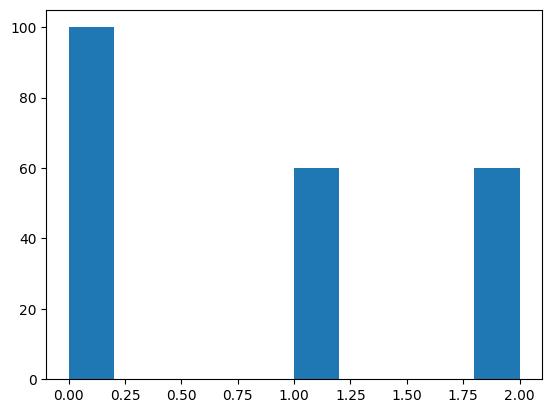

N15_M07_F10_K006_1.mat
N15_M07_F10_K006_2.mat
N15_M07_F10_K006_3.mat
N15_M07_F10_K006_4.mat
N15_M07_F10_K006_5.mat
N15_M07_F10_K006_6.mat
N15_M07_F10_K006_7.mat
N15_M07_F10_K006_8.mat
N15_M07_F10_K006_9.mat
N15_M07_F10_K006_10.mat
N15_M07_F10_K006_11.mat
N15_M07_F10_K006_12.mat
N15_M07_F10_K006_13.mat
N15_M07_F10_K006_14.mat
N15_M07_F10_K006_15.mat
N15_M07_F10_K006_16.mat
N15_M07_F10_K006_17.mat
N15_M07_F10_K006_18.mat
N15_M07_F10_K006_19.mat
N15_M07_F10_K006_20.mat
N15_M07_F10_KI17_1.mat
N15_M07_F10_KI17_2.mat
N15_M07_F10_KI17_3.mat
N15_M07_F10_KI17_4.mat
N15_M07_F10_KI17_5.mat
N15_M07_F10_KI17_6.mat
N15_M07_F10_KI17_7.mat
N15_M07_F10_KI17_8.mat
N15_M07_F10_KI17_9.mat
N15_M07_F10_KI17_10.mat
N15_M07_F10_KI17_11.mat
N15_M07_F10_KI17_12.mat
N15_M07_F10_KI17_13.mat
N15_M07_F10_KI17_14.mat
N15_M07_F10_KI17_15.mat
N15_M07_F10_KI17_16.mat
N15_M07_F10_KI17_17.mat
N15_M07_F10_KI17_18.mat
N15_M07_F10_KI17_19.mat
N15_M07_F10_KI17_20.mat
N15_M07_F10_KI18_1.mat
N15_M07_F10_KI18_2.mat
N15_M07_F10_

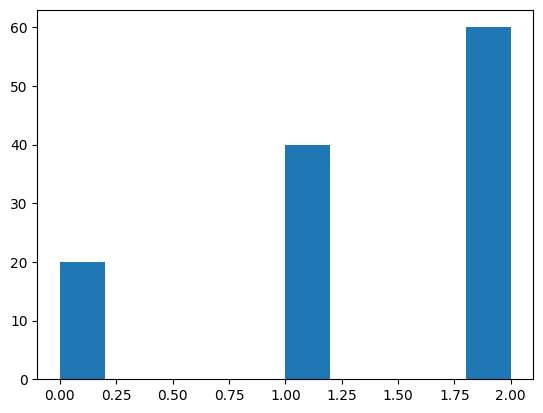

In [ ]:
training_dataset, testing_dataset = getDataset(code,signal="vibration",width=256000,ratios="6:5");

In [ ]:
training_dataloader = DataLoader(training_dataset, batch_size=32, shuffle=True);
testing_dataloader = DataLoader(testing_dataset, batch_size=32, shuffle=True);

#### Transformer Model Creation

In [ ]:
class Transformer(nn.Module):
    def __init__(self, seq_len=250, input_dim=1024, d_model=128, nhead=8, num_encoder_layers=4, dim_feedforward=256, num_classes=3):
        super(Transformer, self).__init__();

        self.positional_encoding = nn.Embedding(seq_len, input_dim);

        encoder_layer = nn.TransformerEncoderLayer(d_model = input_dim,
                                                   nhead = nhead,
                                                   dim_feedforward = dim_feedforward,
                                                   activation='gelu',
                                                   batch_first = True);

        self.transformer_encoder = nn.TransformerEncoder(
            encoder_layer,
            num_layers = num_encoder_layers
        );

        self.fc1 = nn.Linear(input_dim, seq_len//2);
        self.fc2 = nn.Linear(seq_len//2, 3);

        self.gelu = nn.GELU();

    def forward(self, x):
        batch_size, seq_len, input_dim = x.shape;

        x = x + self.positional_encoding(
            torch.arange(0, seq_len).to(device)
        );

        x = self.transformer_encoder(x);

        x = self.fc1(x);
        x = self.gelu(x);

        x = self.fc2(x);

        return x;

In [ ]:
model = Transformer();
model.to(device);

print(model);

Transformer(
  (positional_encoding): Embedding(250, 1024)
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-3): 4 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=1024, out_features=1024, bias=True)
        )
        (linear1): Linear(in_features=1024, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=1024, bias=True)
        (norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc1): Linear(in_features=1024, out_features=125, bias=True)
  (fc2): Linear(in_features=125, out_features=3, bias=True)
  (gelu): GELU(approximate='none')
)


In [ ]:
loss = nn.CrossEntropyLoss();
optimizer = torch.optim.AdamW(model.parameters(), lr = 0.00001);

In [ ]:
accuracy = Accuracy(task="multiclass", num_classes=3).to(device);
precision = Precision(task="multiclass", num_classes=3).to(device);
recall = Recall(task="multiclass", num_classes=3).to(device);
f1_score = F1Score(task="multiclass", num_classes=3).to(device);
conf_matrix_metric = ConfusionMatrix(task="multiclass", num_classes=3).to(device);

In [ ]:
result_dir = "/content/drive/MyDrive/Results/Transformer";
if not os.path.exists(result_dir):
    os.makedirs(result_dir);

In [ ]:
epochs = 100;

#### Model Training

In [ ]:
metrics_list = [];

for epoch in range(epochs):

    train_loss_per_epoch = [];
    test_loss_per_epcoh = [];

    train_acc_per_epoch = [];
    test_acc_per_epoch = [];

    train_precision_per_epoch = [];
    test_precision_per_epoch = [];

    train_recall_per_epoch = [];
    test_recall_per_epoch = [];

    train_f1_per_epoch = [];
    test_f1_per_epoch = [];

    traing_cf = np.zeros((3,3));
    test_cf = np.zeros((3,3));

    model.train();
    for x, y in training_dataloader:
        optimizer.zero_grad();
        x = x.to(device);
        y = y.to(device);

        y_pred = model(x);

        loss_value = loss(y_pred.view(-1,3), y.view(-1));

        loss_value.backward();
        optimizer.step();

        y_pred = y_pred.argmax(dim=-1);

        y_pred_mm,_ = torch.mode(y_pred, dim=-1);
        y_mm,_ = torch.mode(y, dim=-1);

        acc = accuracy(y_pred_mm, y_mm);
        prec = precision(y_pred_mm, y_mm);
        rec = recall(y_pred_mm, y_mm);
        f1 = f1_score(y_pred_mm, y_mm);
        conf_matrix = conf_matrix_metric(y_pred_mm, y_mm);

        traing_cf += conf_matrix.cpu().numpy();

        train_loss_per_epoch.append(loss_value.item());
        train_acc_per_epoch.append(acc.item());
        train_precision_per_epoch.append(prec.item());
        train_recall_per_epoch.append(rec.item());
        train_f1_per_epoch.append(f1.item());

    model.eval();
    with torch.no_grad():
        for x, y in testing_dataloader:
            x = x.to(device);
            y = y.to(device);

            y_pred = model(x);

            loss_value = loss(y_pred.view(-1,3), y.view(-1));

            y_pred = y_pred.argmax(dim=-1);

            y_pred_mm,_ = torch.mode(y_pred, dim=-1);
            y_mm,_ = torch.mode(y, dim=-1);

            acc = accuracy(y_pred_mm, y_mm);
            prec = precision(y_pred_mm, y_mm);
            rec = recall(y_pred_mm, y_mm);
            f1 = f1_score(y_pred_mm, y_mm);
            conf_matrix = conf_matrix_metric(y_pred_mm, y_mm);

            test_cf += conf_matrix.cpu().numpy();

            test_loss_per_epcoh.append(loss_value.item());
            test_acc_per_epoch.append(acc.item());
            test_precision_per_epoch.append(prec.item());
            test_recall_per_epoch.append(rec.item());
            test_f1_per_epoch.append(f1.item());


    metrics_list.append({
        "train_loss": np.mean(train_loss_per_epoch),
        "test_loss": np.mean(test_loss_per_epcoh),
        "train_acc": np.mean(train_acc_per_epoch),
        "test_acc": np.mean(test_acc_per_epoch),
        "train_precision": np.mean(train_precision_per_epoch),
        "test_precision": np.mean(test_precision_per_epoch),
        "train_recall": np.mean(train_recall_per_epoch),
        "test_recall": np.mean(test_recall_per_epoch),
        "train_f1": np.mean(train_f1_per_epoch),
        "test_f1": np.mean(test_f1_per_epoch),
        "train_cf": json.dumps(traing_cf.tolist()),
        "test_cf": json.dumps(test_cf.tolist())
    });

    maxx = max(metrics_list, key=lambda x: x["test_f1"]);

    if maxx["test_f1"] <= metrics_list[-1]["test_f1"]:
        torch.save(model.state_dict(), os.path.join(result_dir,"bb_mm.pth"));

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {metrics_list[-1]['train_loss']:.4f} | Test Loss: {metrics_list[-1]['test_loss']:.4f} | Train Acc: {metrics_list[-1]['train_acc']:.4f} | Test Acc: {metrics_list[-1]['test_acc']:.4f} | Train F1: {metrics_list[-1]['train_f1']:.4f} | Test F1: {metrics_list[-1]['test_f1']:.4f}");

Epoch 1/100 | Train Loss: 1.0775 | Test Loss: 1.3985 | Train Acc: 0.4273 | Test Acc: 0.1615 | Train F1: 0.4273 | Test F1: 0.1615
Epoch 2/100 | Train Loss: 1.0381 | Test Loss: 1.1674 | Train Acc: 0.4534 | Test Acc: 0.1693 | Train F1: 0.4534 | Test F1: 0.1693
Epoch 3/100 | Train Loss: 0.9787 | Test Loss: 1.2865 | Train Acc: 0.5733 | Test Acc: 0.1693 | Train F1: 0.5733 | Test F1: 0.1693
Epoch 4/100 | Train Loss: 0.7303 | Test Loss: 1.4224 | Train Acc: 0.6429 | Test Acc: 0.2995 | Train F1: 0.6429 | Test F1: 0.2995
Epoch 5/100 | Train Loss: 0.2375 | Test Loss: 3.9817 | Train Acc: 0.9630 | Test Acc: 0.2005 | Train F1: 0.9630 | Test F1: 0.2005
Epoch 6/100 | Train Loss: 0.0814 | Test Loss: 3.9682 | Train Acc: 0.9815 | Test Acc: 0.3281 | Train F1: 0.9815 | Test F1: 0.3281
Epoch 7/100 | Train Loss: 0.0331 | Test Loss: 5.1569 | Train Acc: 0.9955 | Test Acc: 0.2812 | Train F1: 0.9955 | Test F1: 0.2812
Epoch 8/100 | Train Loss: 0.0033 | Test Loss: 6.2578 | Train Acc: 1.0000 | Test Acc: 0.2396 | Tra